In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from math import pi
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Data Loading and Initial Exploration

Before performing any analysis, it's crucial to load the dataset and conduct a preliminary exploration to understand its structure and contents. This step involves:
- Loading the data into a Pandas DataFrame.
- Dropping irrelevant or identifying columns (like `ID`).
- Examining the dataset's structure, including the data types, missing values, and summary statistics.

In [37]:
# Loading data
customer_data = pd.read_csv("./marketing_campaign.csv", sep='\t')

# Dropping the ID column
customer_data = customer_data.drop(columns=['ID'])

# Get counts, data types and examine the first portion of the dataframe
print(customer_data.info())
print(customer_data.head())

# Descriptive statistics for the data
print(customer_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

## **Data preprocessing:**

### Dropping Missing Values
We are dropping any rows in the dataset that have missing values, ensuring that only complete records are used in the subsequent analysis. This avoids potential biases from imputation.

### Formatting dates
Dt-customer shows when the customer joined but we need numerical data for PCA so I've taken the first date as 0 and every subsequent date is counted in days since the original date

### One-Hot Encoding
One-hot encoding converts categorical variables like Education and Marital_Status into multiple binary columns, each representing one category. For each row, a 1 is placed in the column corresponding to the actual category, and 0s are placed in the other columns.

### Scaling Numerical Features
Numerical features are then scaled using StandardScaler to ensure all features have a mean of 0 and standard deviation of 1. This helps prevent features with larger ranges from dominating others during PCA and clustering.

In experimenting I was having issues with the date time format so I'm going to process that column first and then do the encoding

In [38]:
# Drop rows with any missing values
customer_data = customer_data.dropna()

# Ensure all entries in 'Dt_Customer' are strings
customer_data['Dt_Customer'] = customer_data['Dt_Customer'].astype(str)

# Function to validate date parts (day, month, year)
def validate_date(row):
    try:
        # Split the date into day, month, year
        day, month, year = map(int, row.split('-'))
        
        # Check if the day, month, and year are within valid ranges
        if day < 1 or day > 31:
            return True
        if month < 1 or month > 12:
            return True
        if year < 1900 or year > datetime.now().year:
            return True
        
        # Attempt to create a valid date, catching invalid combinations (e.g., 31st of Nov)
        datetime(year, month, day)
        return True
    
    except ValueError:
        return False

# Apply the validation function to each row
customer_data['Valid_Date'] = customer_data['Dt_Customer'].apply(validate_date)

# Print out invalid rows
invalid_dates = customer_data[~customer_data['Valid_Date']]
print("Invalid dates found:\n", invalid_dates)

# Filter out invalid dates or fix them manually
customer_data = customer_data[customer_data['Valid_Date']]

# Convert valid dates to datetime format that pandas can handle
customer_data['Dt_Customer'] = pd.to_datetime(customer_data['Dt_Customer'], format='%d-%m-%Y', errors='coerce')

# Drop the 'Valid_Date' column after conversion
customer_data = customer_data.drop(columns=['Valid_Date'])

# Using the date the file was created so that we can determine the longevity of each customer
file_creation_date = pd.Timestamp('22-08-2021')

# Convert Dt_Customer to int representing length of time they've been a customer
customer_data['Days as Customer'] = (file_creation_date - customer_data['Dt_Customer']).dt.days

# Check the result
print(customer_data)

Invalid dates found:
 Empty DataFrame
Columns: [Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response, Valid_Date]
Index: []

[0 rows x 29 columns]
      Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0           1957  Graduation         Single  58138.0        0         0   
1           1954  Graduation         Single  46344.0        1         1   
2           1965  Graduation       Together  71613.0        0         0   
3           1984  Graduation       Together  26646.0        1         0   
4           1981         PhD        Married  58293.0        1         0   
...          ...         ...            ...      ...      ...       ...

In [39]:
# Creating column for Customer Age at time data set was created
customer_data['Customer Age'] = (2021 - customer_data['Year_Birth'])

# Renaming columns before scaling
customer_data.rename(columns={'Income': 'Annual Income',
                              'Kidhome': 'Kids at Home',
                              'Teenhome': 'Teens at Home',
                              'NumDealsPurchases': 'Deals Purchased',
                              'NumCatalogPurchases': 'Catalog Purchases',
                              'NumStorePurchases': 'Store Purchases',
                              'NumWebPurchases': 'Web Purchases',
                              'NumWebVisitsMonth': 'Monthly Web Visits',
                              'MntGoldProds': 'Gold',
                              'MntFishProducts': 'Fish',
                              'MntMeatProducts': 'Meat',
                              'MntSweetProducts': 'Sweets',
                              'MntFruits': 'Fruit',
                              'MntWines': 'Wine',
                              'Recency': 'Customer Recency'}, inplace=True)

customer_data.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)

print(customer_data)

       Education Marital_Status  Annual Income  Kids at Home  Teens at Home  \
0     Graduation         Single        58138.0             0              0   
1     Graduation         Single        46344.0             1              1   
2     Graduation       Together        71613.0             0              0   
3     Graduation       Together        26646.0             1              0   
4            PhD        Married        58293.0             1              0   
...          ...            ...            ...           ...            ...   
2235  Graduation        Married        61223.0             0              1   
2236         PhD       Together        64014.0             2              1   
2237  Graduation       Divorced        56981.0             0              0   
2238      Master       Together        69245.0             0              1   
2239         PhD        Married        52869.0             1              1   

      Customer Recency  Wine  Fruit  Meat  Fish  ..

In [40]:
# One-hot encoding for categorical variables (Education and Marital_Status)
encoded_data = pd.get_dummies(customer_data, columns=['Education', 'Marital_Status'])


# Convert any boolean columns (True/False) to integer (0/1)
encoded_data = encoded_data.astype(int)


# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Customer Age', 'Annual Income', 'Kids at Home', 'Teens at Home', 'Days as Customer', 'Customer Recency', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets', 'Gold', 'Deals Purchased', 'Web Purchases', 'Catalog Purchases', 'Store Purchases', 'Monthly Web Visits']

scaled_data = encoded_data.copy()
scaled_data[numerical_features] = scaler.fit_transform(encoded_data[numerical_features])

scaled_data.head()

,Annual Income,Kids at Home,Teens at Home,Customer Recency,Wine,Fruit,Meat,Fish,Sweets,Gold,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0,0,0,0,0,0,1,0,0,0
1,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,0,0,0,0,0,0,1,0,0,0
2,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,0,0,0,0,0,0,0,1,0,0
3,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0,0,0,0,0,0,0,1,0,0
4,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,0,1,0,0,0,1,0,0,0,0


In [41]:
print(scaled_data[['Customer Age', 'Days as Customer']])

      Customer Age  Days as Customer
0         0.986443          1.529129
1         1.236801         -1.188411
2         0.318822         -0.205155
3        -1.266777         -1.059945
4        -1.016420         -0.951244
...            ...               ...
2235      0.151917          0.135772
2236      1.904422         -1.652863
2237     -1.016420         -0.980889
2238      1.069896         -0.975948
2239      1.236801          1.326548

[2216 rows x 2 columns]


Ok so YOLO and Absurds probably shouldnt be marriage categories so lets look at how many of them there are in the dataset

In [42]:
# Count the occurrences of 0 and 1 in the column
print(scaled_data['Marital_Status_Absurd'].value_counts())

# Count the occurrences of 0 and 1 in the column
print(scaled_data['Marital_Status_YOLO'].value_counts())

# Count the occurrences of 0 and 1 in the column
print(scaled_data['Marital_Status_Married'].value_counts())


Marital_Status_Absurd
0    2214
1       2
Name: count, dtype: int64
Marital_Status_YOLO
0    2214
1       2
Name: count, dtype: int64
Marital_Status_Married
0    1359
1     857
Name: count, dtype: int64


Ok so since there's only 2 Absurd married types and 2 YOLO's I'm just going to leave them in because those columns contribution to the overall variance will be so small that they will likely not change the outcome. I could drop them also but I"m interested in the YOLO crowd and their spending habits, maybe I should check to see if they're outliers in other ways.

In [43]:
print(scaled_data.columns)

Index(['Annual Income', 'Kids at Home', 'Teens at Home', 'Customer Recency',
       'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets', 'Gold', 'Deals Purchased',
       'Web Purchases', 'Catalog Purchases', 'Store Purchases',
       'Monthly Web Visits', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response', 'Days as Customer', 'Customer Age',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')


***Dimensionality Reduction with PCA***

We apply PCA to the scaled data to reduce dimensionality while retaining 90% of the variance. This step helps to simplify the dataset and improve clustering results by focusing on the most significant components.

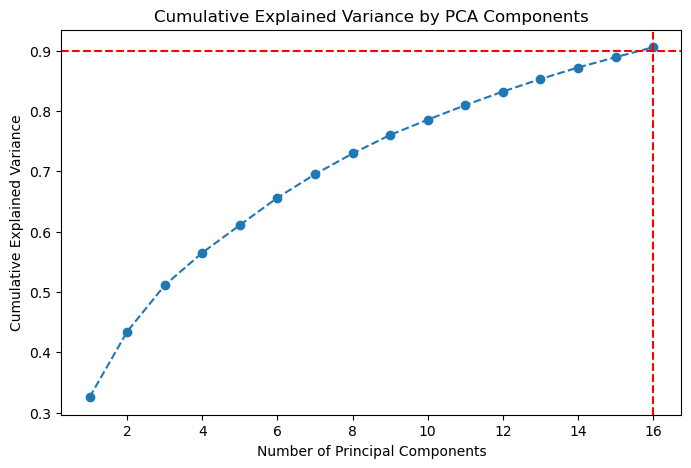

In [44]:
# Apply PCA on the standardized data
pca = PCA(n_components=0.9)  # Retain 90% of variance
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame of the principal components
pca_data = pd.DataFrame(principal_components)

# Calculate the cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--')  # Mark 90% variance line
plt.axvline(x=np.argmax(explained_variance >= 0.9) + 1, color='r', linestyle='--')  # Mark the number of components for 90% variance
plt.show()


***K-means Clustering***

We now apply K-means clustering, using the elbow method to determine the optimal number of clusters. After identifying the best number of clusters, we fit the K-means model and label each customer with their corresponding cluster.

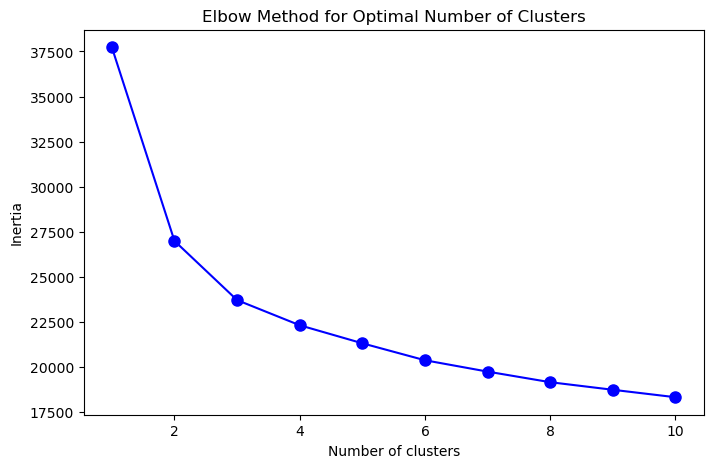

In [45]:
# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [46]:
# Choose the optimal number of clusters and fit the model
optimal_clusters = 3  # Change this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_data)

# Add the cluster labels to the original data
scaled_data['Cluster'] = clusters
scaled_data.head()

,Annual Income,Kids at Home,Teens at Home,Customer Recency,Wine,Fruit,Meat,Fish,Sweets,Gold,...,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Cluster
0,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0,0,0,0,0,1,0,0,0,2
1,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,0,0,0,0,0,1,0,0,0,1
2,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,0,0,0,0,0,0,1,0,0,2
3,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0,0,0,0,0,0,1,0,0,1
4,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,1,0,0,0,1,0,0,0,0,1


## Scatter Plot: Customer Segments Based on Principal Components

This scatter plot visualizes the customer segments based on the **first two principal components** derived from the **PCA (Principal Component Analysis)**. The goal of PCA is to reduce the dimensionality of the dataset while retaining most of the variation in the data. By plotting the first two principal components, we capture the primary patterns and relationships in the dataset that contribute to the variance.

### Purpose:
The scatter plot allows us to visualize how well the clusters are separated in the reduced dimensional space. By plotting customers based on these two components, we can observe how distinct or overlapping the clusters are, which can provide insight into the effectiveness of the clustering algorithm.

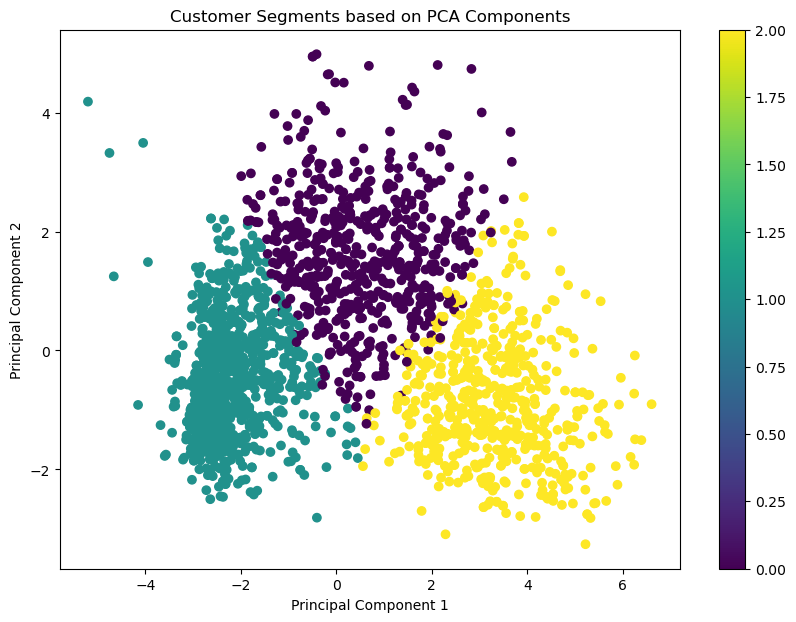

In [47]:
# Scatter plot of clusters based on the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[0], pca_data[1], c=clusters, cmap='viridis', marker='o')
plt.title('Customer Segments based on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

## **Cluster Analysis**

### Radar Chart: Summarizing Key Metrics for Each Cluster
- Use to compare clusters based on mean or median values for each feature.
- Provides a high-level, holistic view of each cluster’s characteristics.
- Helps create personas that describe the typical behavior or profile of each cluster.

### Violin Plots: Exploring Feature Distributions Across Clusters
- Use to examine the full distribution of features within each cluster.
- Highlights variability, concentration, and outliers within each cluster.
- Complements radar charts by showing not just the averages, but also the range and diversity of behaviors within each cluster.

In [48]:
# Create list of all features
all_features = list(scaled_data.columns)
all_features.pop()
all_features.remove('Z_CostContact')
all_features.remove('Z_Revenue')
print(all_features)

['Annual Income', 'Kids at Home', 'Teens at Home', 'Customer Recency', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets', 'Gold', 'Deals Purchased', 'Web Purchases', 'Catalog Purchases', 'Store Purchases', 'Monthly Web Visits', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Days as Customer', 'Customer Age', 'Education_2n Cycle', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow', 'Marital_Status_YOLO']


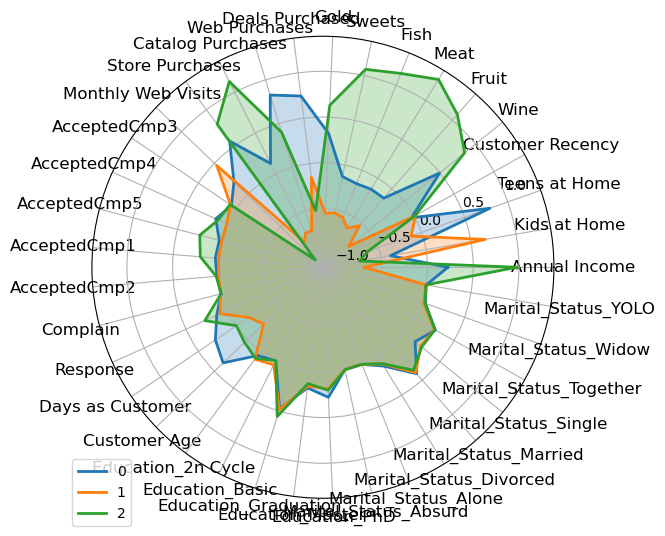

In [49]:
# Function to create a radar chart
def create_radar_chart(cluster_data, features, cluster_names):
    # Number of features
    num_vars = len(features)

    # Split the circle into even parts for each feature
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for i, cluster in enumerate(cluster_data):
        values = cluster.tolist()
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=cluster_names[i])
        ax.fill(angles, values, alpha=0.25)

    # Add labels for each feature
    plt.xticks(angles[:-1], features, size=12)

    # Draw one cluster at a time and add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Calculate the average values for each cluster
cluster_averages = scaled_data.groupby('Cluster').mean()

# Select the clusters you want to compare (e.g., clusters 0 and 1)
cluster_ids_to_compare = [0, 1, 2]

# Get the data for selected clusters
selected_clusters = cluster_averages.loc[cluster_ids_to_compare, all_features]

# Create radar chart for the selected clusters
create_radar_chart(selected_clusters.values, all_features, cluster_ids_to_compare)


**It looks like only the numerical features differentiate the customers much more than the categorical features, so I'll produce a radar chart that only includes the numerical features so that its less cluttered**

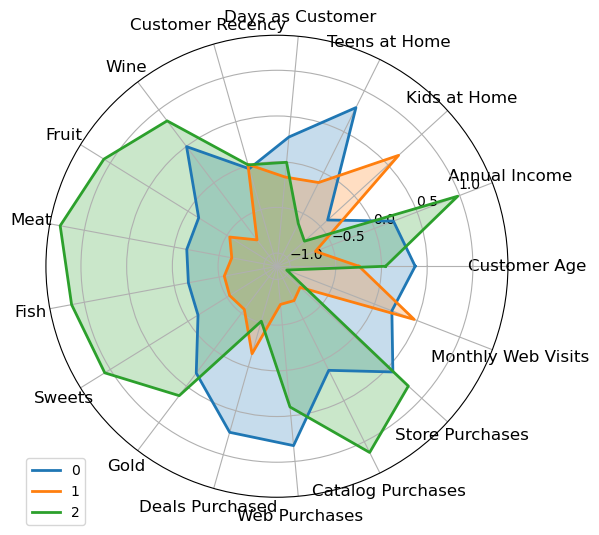

In [50]:
# Create data frame with only numerical features
scaled_data_numerical = scaled_data[['Cluster'] + numerical_features]

# Calculate the average values for each cluster
cluster_averages_numerical = scaled_data_numerical.groupby('Cluster').mean()

# Get the data for selected clusters
selected_clusters_numerical = cluster_averages_numerical.loc[cluster_ids_to_compare, numerical_features]

# Create radar chart for the selected clusters
create_radar_chart(selected_clusters_numerical.values, numerical_features, cluster_ids_to_compare)

<Figure size 1500x1000 with 0 Axes>

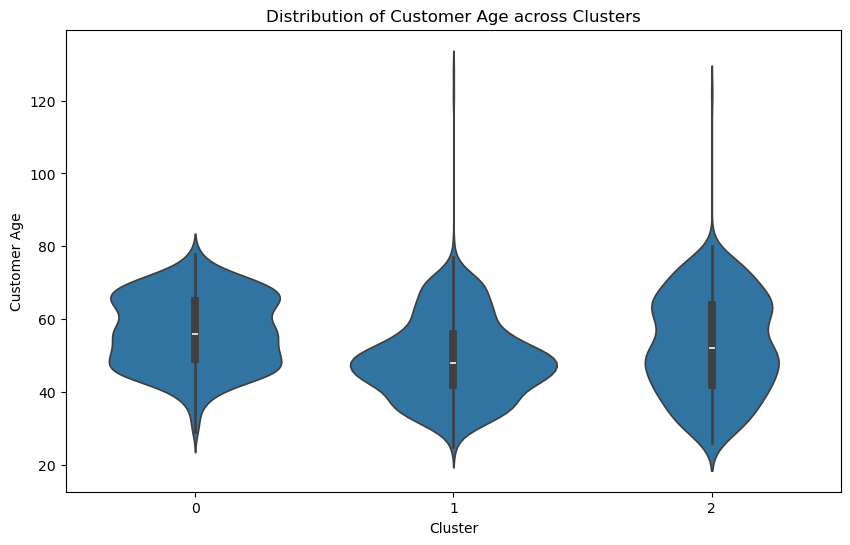

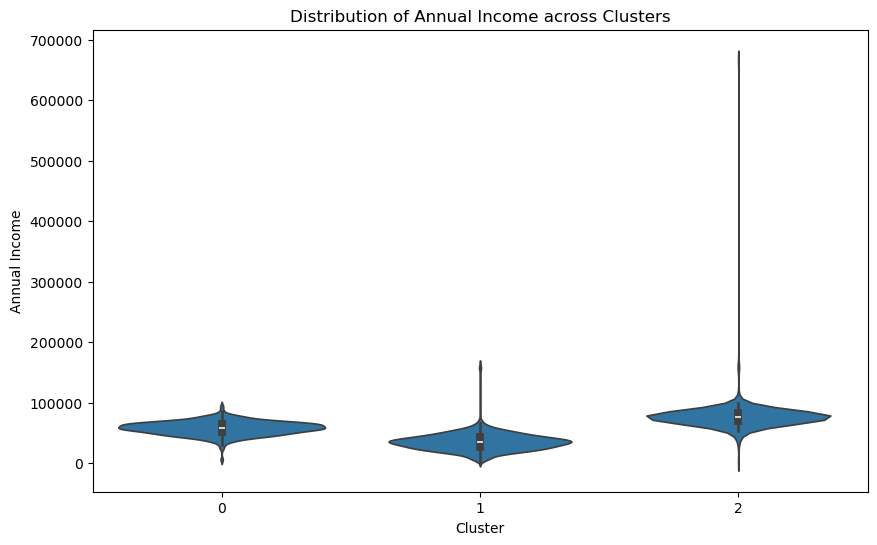

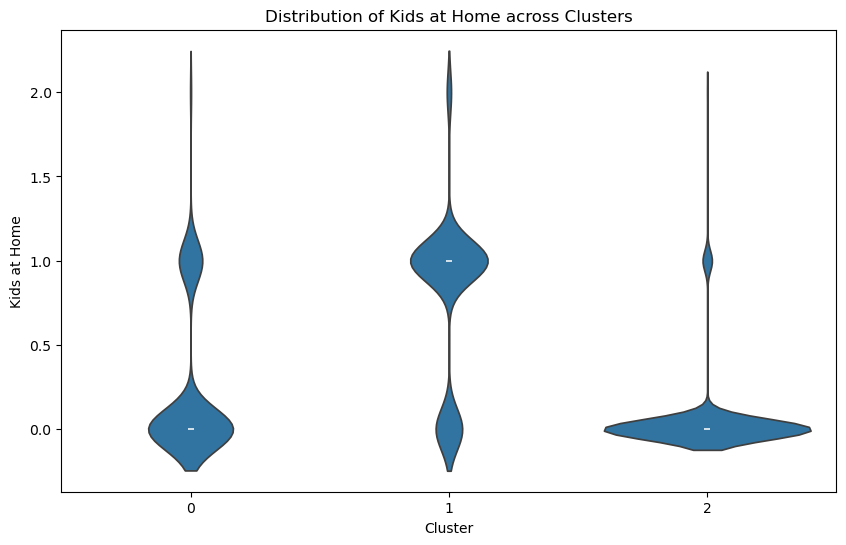

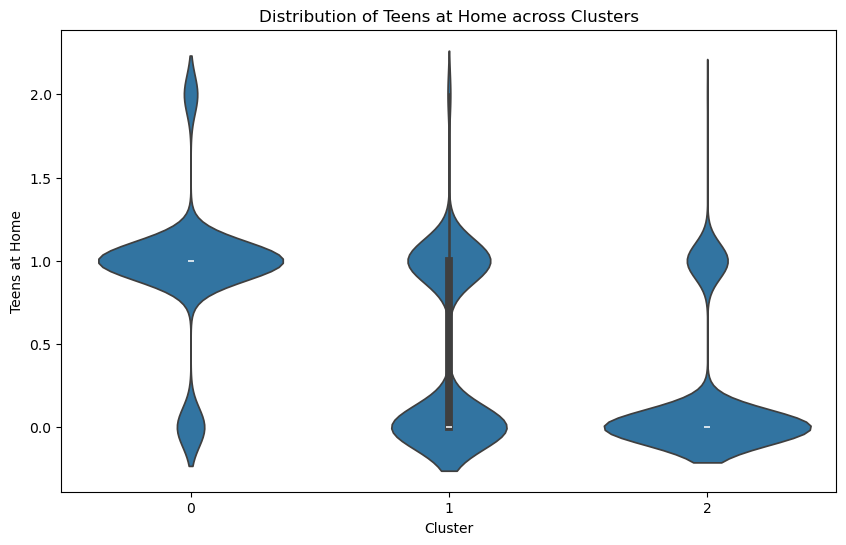

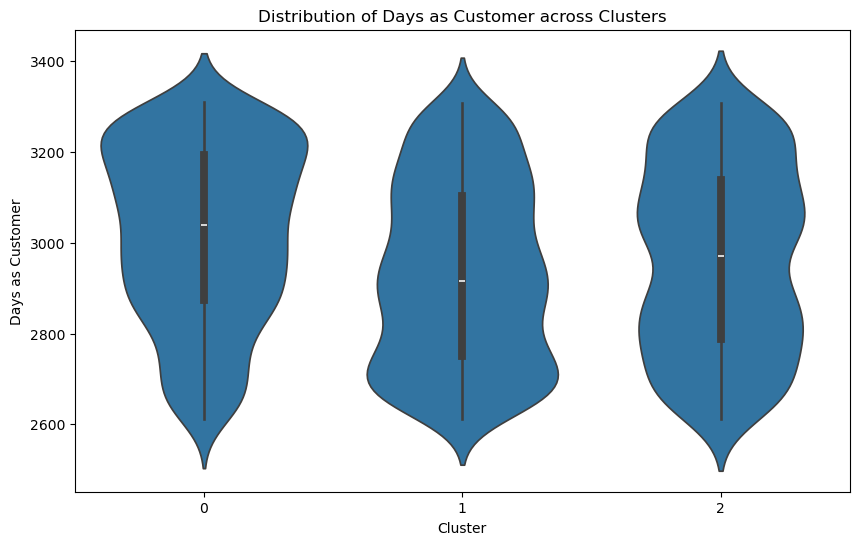

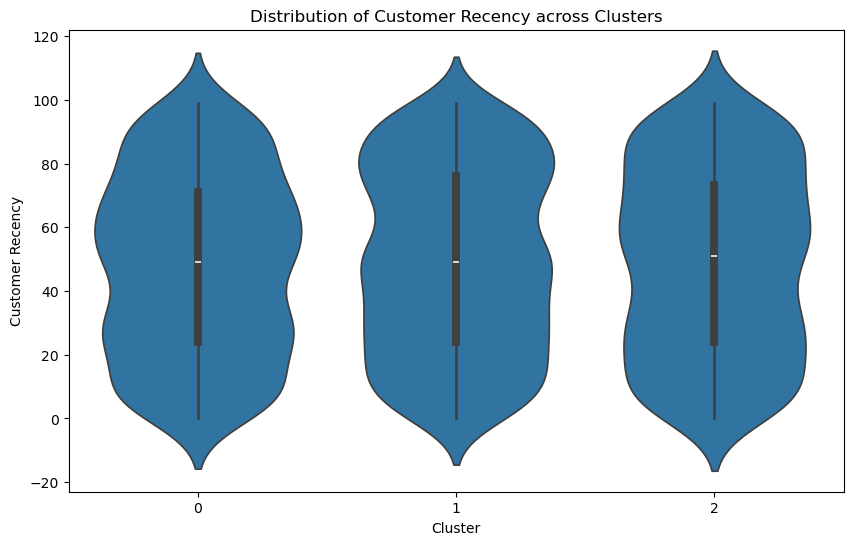

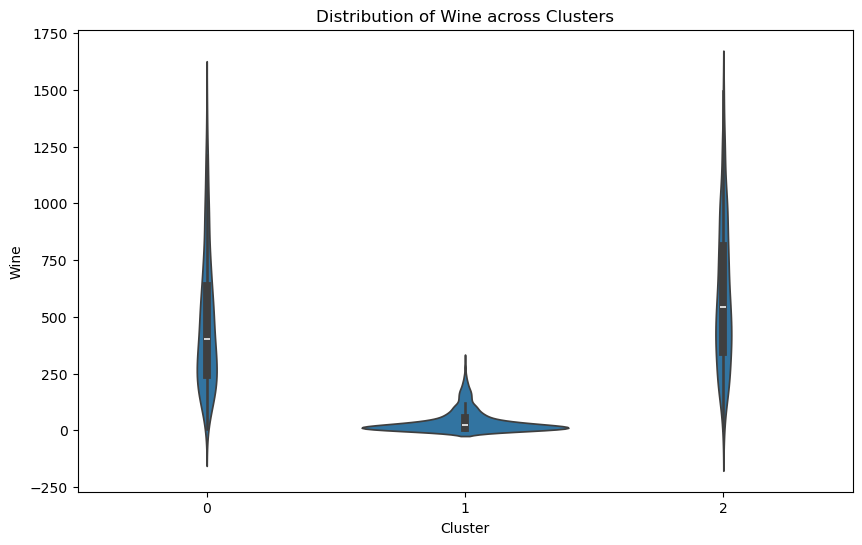

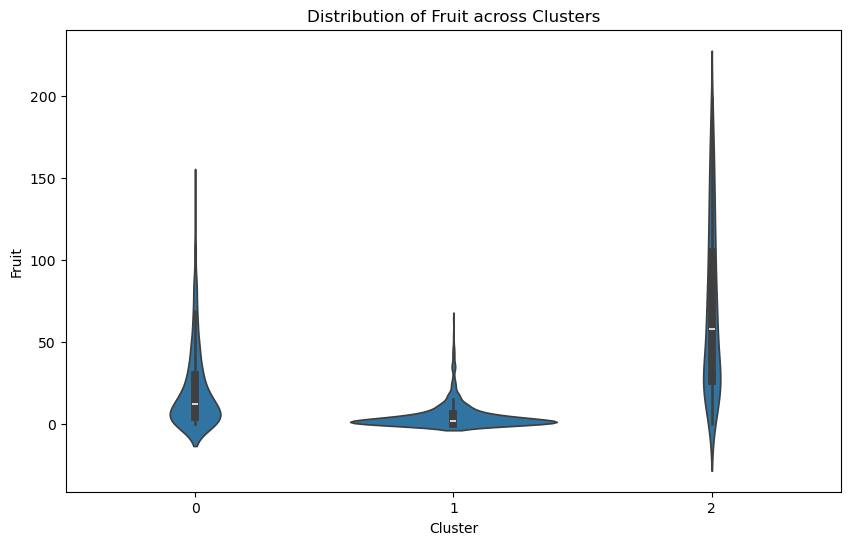

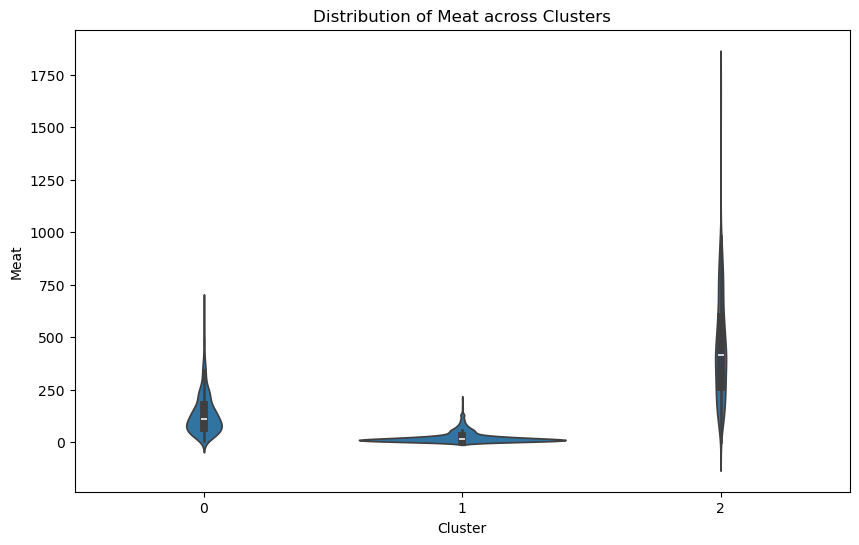

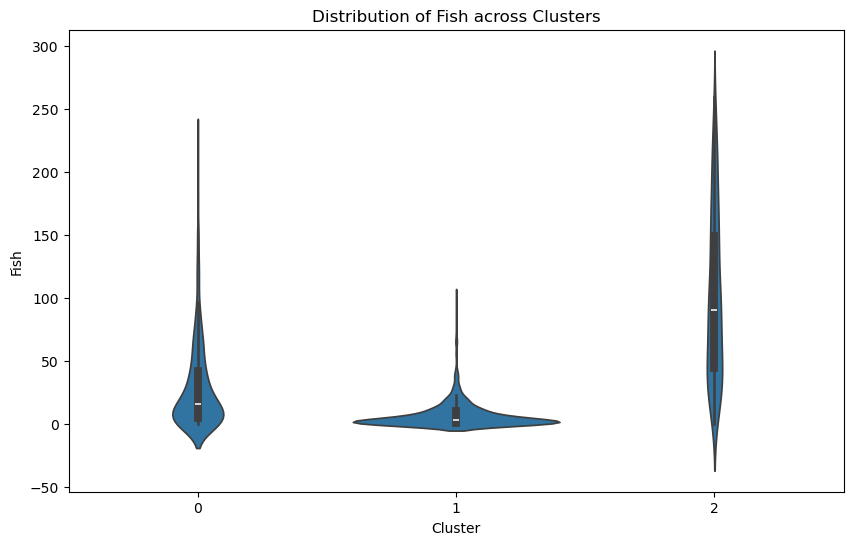

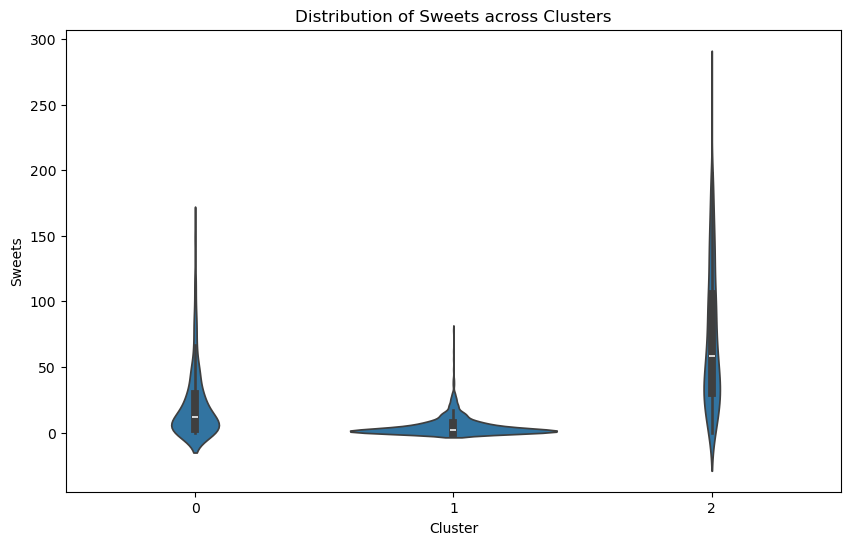

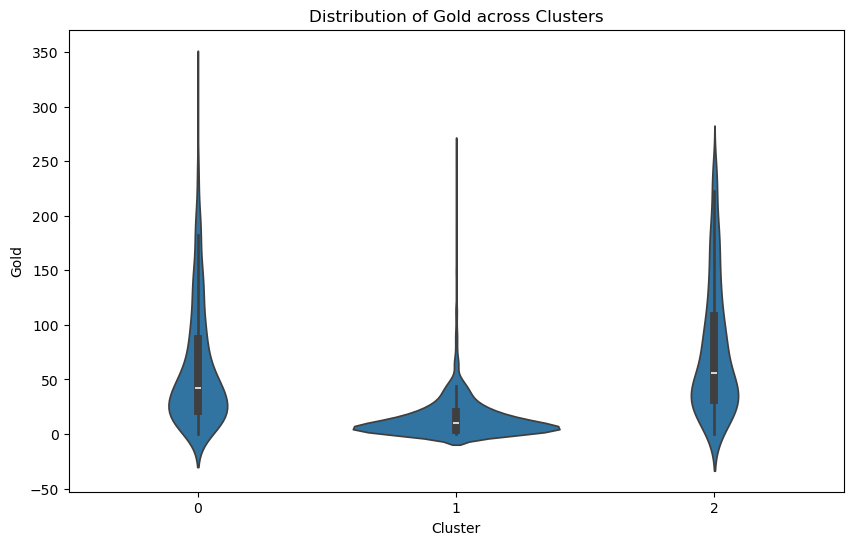

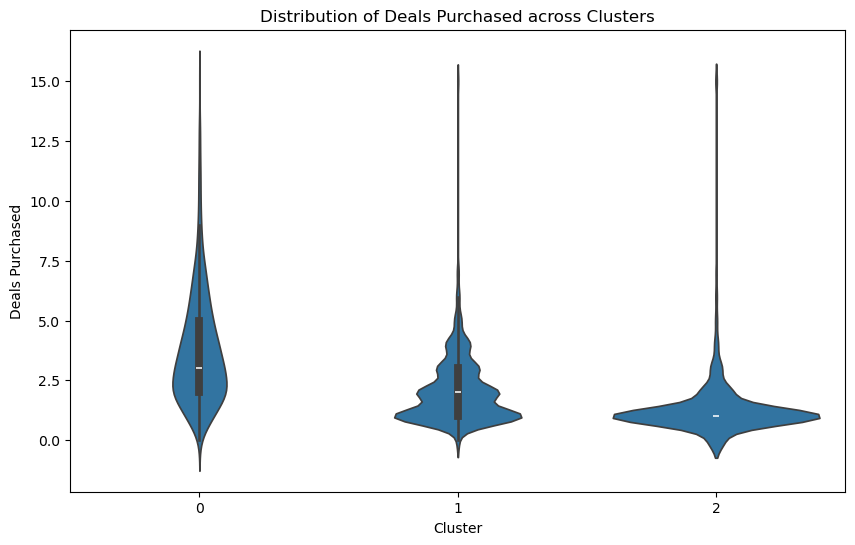

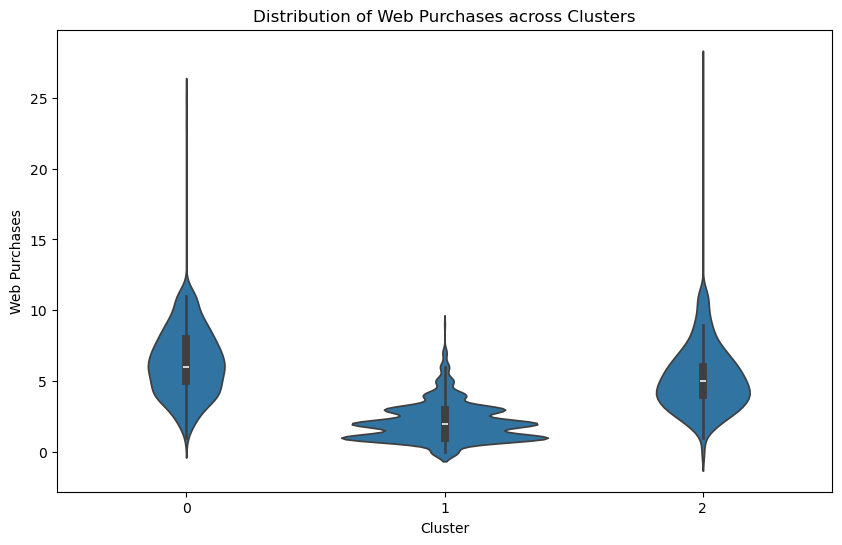

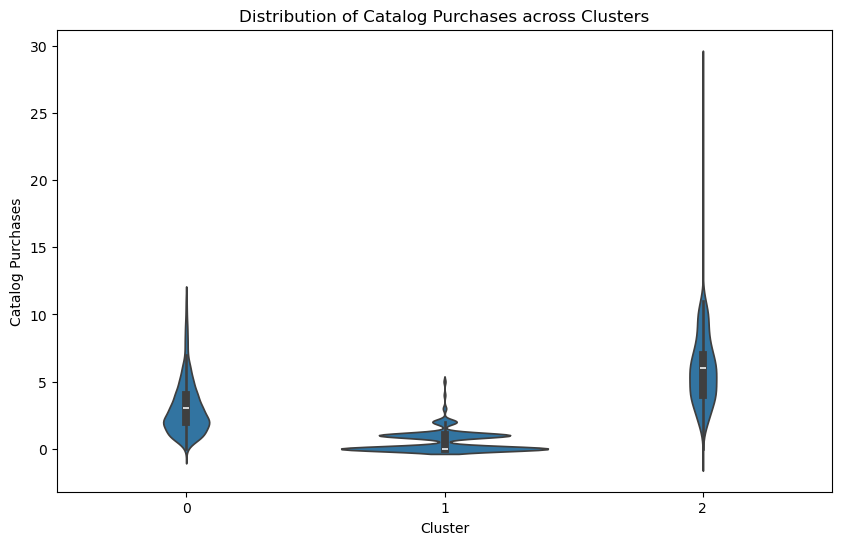

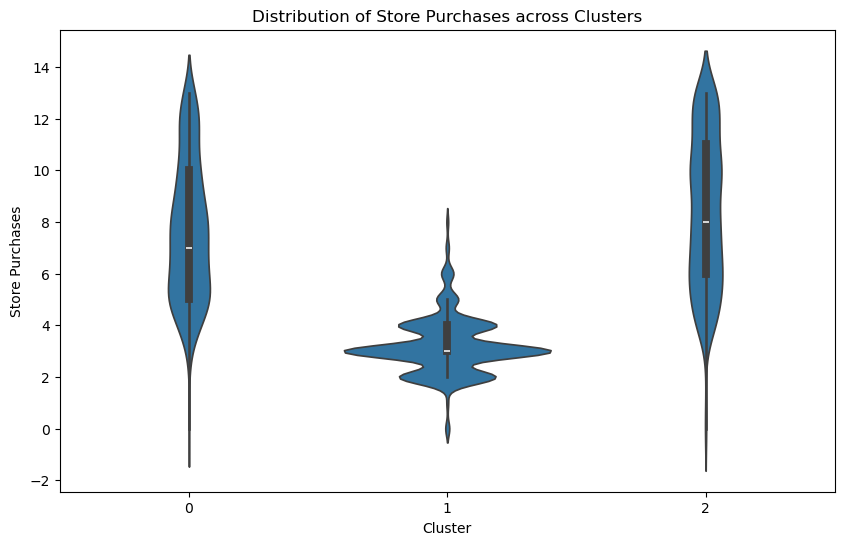

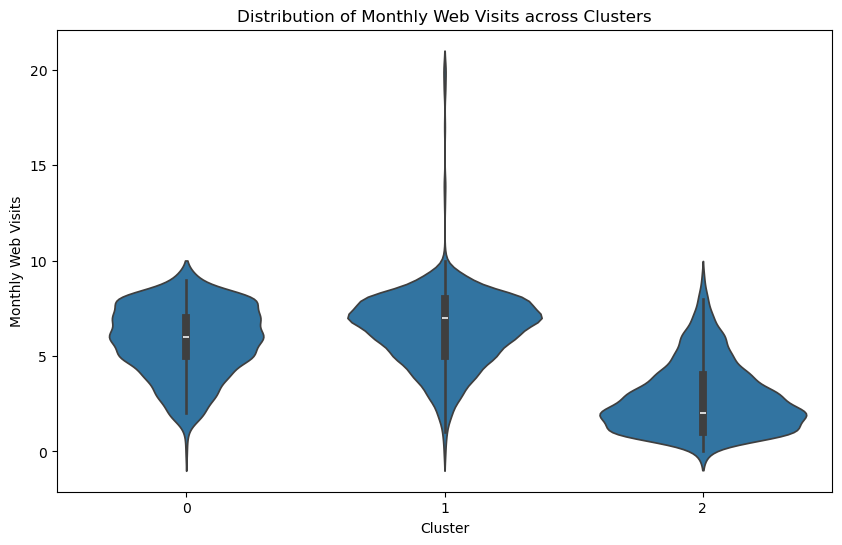

In [51]:
# Add the cluster labels to the original dataset
customer_data['Cluster'] = scaled_data['Cluster'].values

# Plot violin plots for each feature, separated by cluster
plt.figure(figsize=(15, 10))


for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Cluster', y=feature, data=customer_data)
    plt.title(f'Distribution of {feature} across Clusters')
    plt.show()

In [57]:
# Recreate list of numerical features with Cluster added
numerical_features = ['Customer Age', 'Annual Income', 'Kids at Home', 'Teens at Home', 'Days as Customer', 'Customer Recency', 'Wine', 'Fruit', 'Meat', 'Fish', 'Sweets', 'Gold', 'Deals Purchased', 'Web Purchases', 'Catalog Purchases', 'Store Purchases', 'Monthly Web Visits', 'Cluster']


# Create data frame with just numerical features un scaled
customer_data_numerical = customer_data[numerical_features]

# Drop first column that is a copy of the index
customer_data_numerical = customer_data_numerical.drop(customer_data_numerical.columns[0], axis=1)

print(customer_data_numerical)



      Annual Income  Kids at Home  Teens at Home  Days as Customer  \
0           58138.0             0              0              3274   
1           46344.0             1              1              2724   
2           71613.0             0              0              2923   
3           26646.0             1              0              2750   
4           58293.0             1              0              2772   
...             ...           ...            ...               ...   
2235        61223.0             0              1              2992   
2236        64014.0             2              1              2630   
2237        56981.0             0              0              2766   
2238        69245.0             0              1              2767   
2239        52869.0             1              1              3233   

      Customer Recency  Wine  Fruit  Meat  Fish  Sweets  Gold  \
0                   58   635     88   546   172      88    88   
1                   38    11 

In [58]:
# Exporting scaled data, scaled numerical and original data with clusters added for further visualization
scaled_data.to_csv('scaled_data.csv')
scaled_data_numerical.to_csv('scaled_data_numerical.csv')
customer_data.to_csv('customer_data_clustered.csv') 
customer_data_numerical.to_csv('customer_data_numerical.csv')

In [59]:
print(customer_data_numerical.groupby('Cluster').mean())

         Annual Income  Kids at Home  Teens at Home  Days as Customer  \
Cluster                                                                 
0         57852.001637      0.230769       0.937807       3020.378069   
1         34828.125367      0.794319       0.439765       2931.303624   
2         76837.020548      0.046233       0.167808       2964.155822   

         Customer Recency        Wine      Fruit        Meat        Fish  \
Cluster                                                                    
0               48.006547  472.387889  20.903437  135.499182   28.967267   
1               49.457395   41.156709   4.984329   23.172380    7.091087   
2               49.287671  591.494863  69.424658  451.393836  100.113014   

            Sweets       Gold  Deals Purchased  Web Purchases  \
Cluster                                                         
0        21.746318  60.577741         3.756137       6.350245   
1         5.029383  15.352595         2.037218       2.099